## Implementation of Convolutional Neural Network
Prepared by: Prof. Seth H. Huang


Import required libraries and fetch the data:

In [ ]:
pip install yfinance pandas numpy matplotlib scikit-learn torch

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, Dense, Flatten

# Download historical energy prices (e.g., crude oil) using the Yahoo Finance API
symbol = "CLF"  # Crude oil futures
start_date = "2010-01-01"
end_date = "2022-12-31"

data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
def generate_technical_indicators(df):
    # Example indicators: simple moving average (SMA) and relative strength index (RSI)
    # Adjust window sizes for the indicators as needed
    sma_window = 10
    rsi_window = 14

    df["SMA"] = df["Close"].rolling(window=sma_window).mean()
    delta = df["Close"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    return df

data = generate_technical_indicators(data)

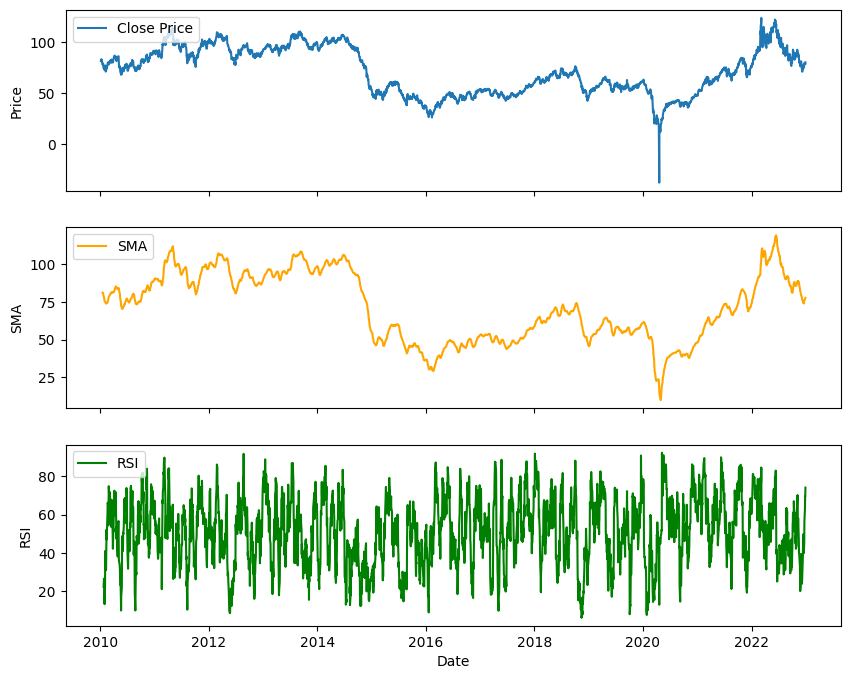

In [ ]:
def plot_technical_indicators(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    ax1.plot(df["Close"], label="Close Price")
    ax1.set_ylabel("Price")
    ax1.legend(loc="upper left")

    ax2.plot(df["SMA"], label="SMA", color="orange")
    ax2.set_ylabel("SMA")
    ax2.legend(loc="upper left")

    ax3.plot(df["RSI"], label="RSI", color="green")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("RSI")
    ax3.legend(loc="upper left")

    plt.show()

plot_technical_indicators(data)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Drop rows with NaN values and reset the index
data = data.dropna().reset_index(drop=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Close", "SMA", "RSI"]])

# Define the lookback period for input data
lookback = 30

# Generate input (X) and output (y) sequences
X, y = [], []
for i in range(len(scaled_data) - lookback):
    X.append(scaled_data[i:i + lookback])
    y.append(scaled_data[i + lookback, 0])  # The target value is the closing price

X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Convert the data to PyTorch tensors
X_train, X_val, X_test = torch.FloatTensor(X_train), torch.FloatTensor(X_val), torch.FloatTensor(X_test)
y_train, y_val, y_test = torch.FloatTensor(y_train), torch.FloatTensor(y_val), torch.FloatTensor(y_test)

# Create DataLoader objects for easier batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss >= self.best_loss:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'best_model.pt')
        print('Checkpoint saved')

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * lookback, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose the input tensor dimensions
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())
early_stopping = EarlyStopping(patience=20)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

Epoch 1/50, Loss: 0.009325524940053788, Val Loss: 8.436205030193378e-05
Checkpoint saved
Epoch 2/50, Loss: 0.0010698179529510885, Val Loss: 0.00012383928299186664
EarlyStopping counter: 1 out of 20
Epoch 3/50, Loss: 0.0007271602476002569, Val Loss: 7.042573599846946e-05
Checkpoint saved
Epoch 4/50, Loss: 0.0005786827182098829, Val Loss: 5.040825271862559e-05
Checkpoint saved
Epoch 5/50, Loss: 0.0004129706235097485, Val Loss: 5.154637761961567e-05
EarlyStopping counter: 1 out of 20
Epoch 6/50, Loss: 0.0004014344997646641, Val Loss: 3.447773144671373e-05
Checkpoint saved
Epoch 7/50, Loss: 0.0003247391665149414, Val Loss: 3.368887337273918e-05
Checkpoint saved
Epoch 8/50, Loss: 0.00041602944695344853, Val Loss: 4.367303463936878e-05
EarlyStopping counter: 1 out of 20
Epoch 9/50, Loss: 0.00029741289554422877, Val Loss: 5.372537412995371e-05
EarlyStopping counter: 2 out of 20
Epoch 10/50, Loss: 0.00032303144961216775, Val Loss: 0.00010017692500241537
EarlyStopping counter: 3 out of 20
Epoch

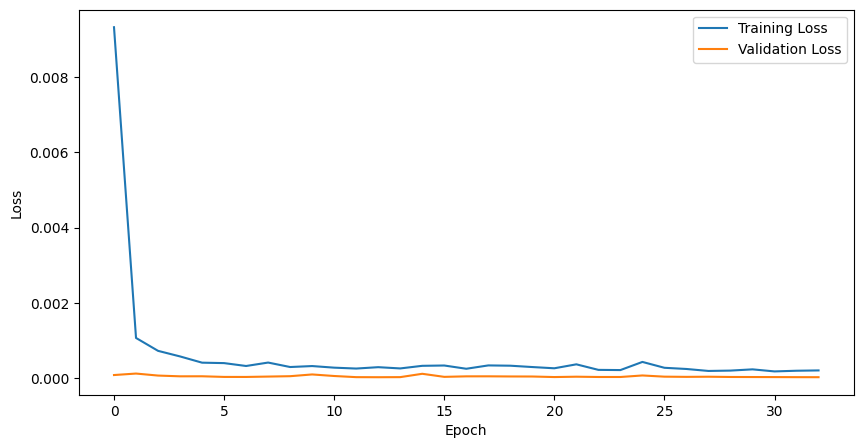

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

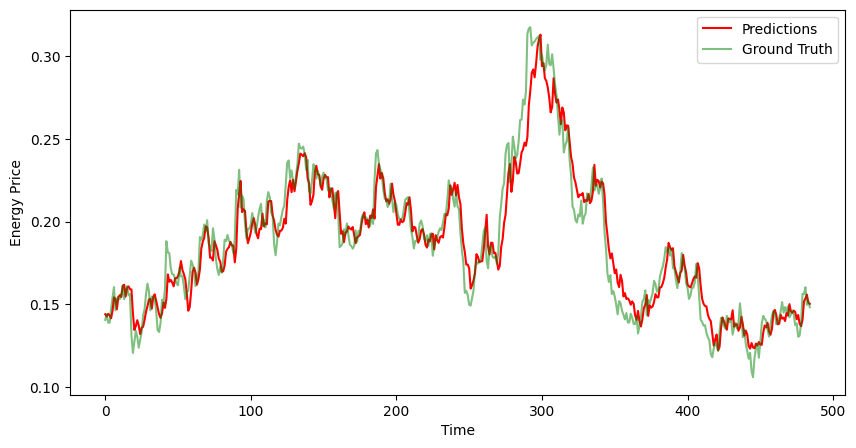

In [ ]:
# Obtain model predictions on the test set
cnn_model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        ground_truth.extend(targets.cpu().numpy())

# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', color='r')
plt.plot(ground_truth, label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

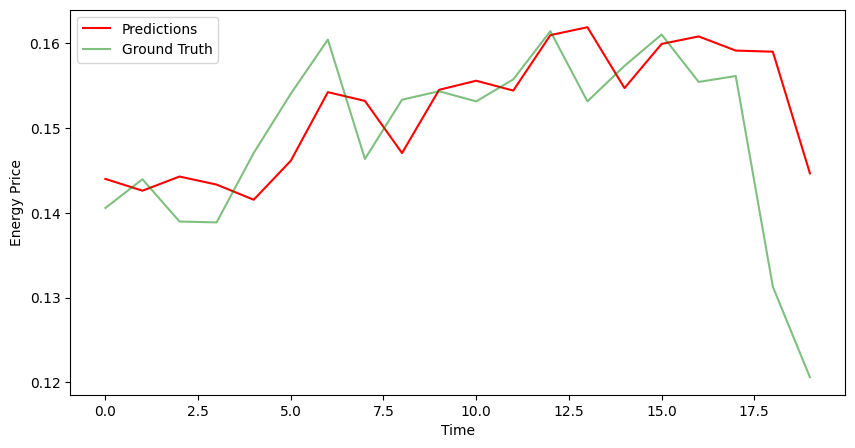

In [ ]:
# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions[0:20], label='Predictions', color='r')
plt.plot(ground_truth[0:20], label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

## Now, perhaps that's not very intuitive. Let's see what the prediction accuracies are for up and down predictions

In [ ]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())
early_stopping = EarlyStopping(patience=20)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 50

def calc_up_down_accuracy(outputs, targets):
    up_down_pred = torch.sign(outputs[1:] - outputs[:-1])
    up_down_target = torch.sign(targets[1:] - targets[:-1])
    accuracy = (up_down_pred == up_down_target).float().mean().item()
    return accuracy

# Initialize counters for training and validation up/down accuracy
train_up_down_accuracy_list = []
val_up_down_accuracy_list = []

# Modify the training loop to include up/down accuracy calculation
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    train_up_down_correct = 0
    train_samples = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
        train_samples += 1

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_up_down_accuracy = train_up_down_correct / train_samples
    train_up_down_accuracy_list.append(train_up_down_accuracy)

    # Validation
    cnn_model.eval()
    val_loss = 0
    val_up_down_correct = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

            val_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
            val_samples += 1

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_up_down_accuracy = val_up_down_correct / val_samples
    val_up_down_accuracy_list.append(val_up_down_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}, Train Up/Down Acc: {train_up_down_accuracy}, Val Up/Down Acc: {val_up_down_accuracy}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

Epoch 1/50, Loss: 0.008804548186623871, Val Loss: 0.00021880345411773305, Train Up/Down Acc: 0.9265644693038833, Val Up/Down Acc: 0.508736552670598
Checkpoint saved
Epoch 2/50, Loss: 0.0008142347602111379, Val Loss: 6.690021746180719e-05, Train Up/Down Acc: 0.9631985341998893, Val Up/Down Acc: 0.4758064430207014
Checkpoint saved
Epoch 3/50, Loss: 0.0005637598508873849, Val Loss: 4.204887005698765e-05, Train Up/Down Acc: 0.9786460601108175, Val Up/Down Acc: 0.439516119658947
Checkpoint saved
Epoch 4/50, Loss: 0.00048711545917887606, Val Loss: 3.7814026484284113e-05, Train Up/Down Acc: 0.9747243960138777, Val Up/Down Acc: 0.4576612804085016
Checkpoint saved
Epoch 5/50, Loss: 0.0004433313600676344, Val Loss: 5.912982203426509e-05, Train Up/Down Acc: 0.9763743667535378, Val Up/Down Acc: 0.46370966732501984
EarlyStopping counter: 1 out of 20
Epoch 6/50, Loss: 0.00045925170225402813, Val Loss: 3.6153146595552244e-05, Train Up/Down Acc: 0.9779047705757786, Val Up/Down Acc: 0.47177418507635593

###  It seems to be quite over-fitted. To prevent overfitting in your CNN model, we can apply several best practices, including regularization, dropout, data augmentation, and hyperparameter tuning. The following steps are what a quant strategist goes through to update the CNN architecture accordingly:

Add Dropout layers:
Dropout layers randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting by introducing some noise into the model.

Add Batch Normalization layers:
Batch Normalization normalizes the input features to have a mean of 0 and a variance of 1, which can help the model generalize better and speed up training.

Add weight decay to the optimizer:
Weight decay (L2 regularization) adds a penalty term to the loss function based on the weights' magnitude, which helps prevent overfitting by discouraging large weights.

Use data augmentation (if applicable):
Data augmentation can be applied when dealing with images or time series data. It generates new training samples by applying random transformations to the original data, which helps the model generalize better.

## can we improve the model?

In [ ]:
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * lookback, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose the input tensor dimensions
        x = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel(dropout_rate=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
early_stopping = EarlyStopping(patience=50)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 300

# Add scheduler.step() to the training loop
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    train_up_down_correct = 0
    train_samples = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
        train_samples += 1

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_up_down_accuracy = train_up_down_correct / train_samples
    train_up_down_accuracy_list.append(train_up_down_accuracy)

    # Validation
    cnn_model.eval()
    val_loss = 0
    val_up_down_correct = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

            val_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
            val_samples += 1

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_up_down_accuracy = val_up_down_correct / val_samples
    val_up_down_accuracy_list.append(val_up_down_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}, Train Up/Down Acc: {train_up_down_accuracy}, Val Up/Down Acc: {val_up_down_accuracy}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

    # Update the learning rate scheduler
    scheduler.step()

Epoch 1/300, Loss: 0.033750860550126036, Val Loss: 0.0013120470639478299, Train Up/Down Acc: 0.8372270872055645, Val Up/Down Acc: 0.4623655825853348
Checkpoint saved
Epoch 2/300, Loss: 0.006417483793125606, Val Loss: 0.0020568982581607997, Train Up/Down Acc: 0.8823740306034894, Val Up/Down Acc: 0.4361559059470892
EarlyStopping counter: 1 out of 50
Epoch 3/300, Loss: 0.005805833268464661, Val Loss: 0.0007083192840582342, Train Up/Down Acc: 0.8915803709500273, Val Up/Down Acc: 0.4543010648339987
Checkpoint saved
Epoch 4/300, Loss: 0.0061346911726860515, Val Loss: 0.000714447542122798, Train Up/Down Acc: 0.902532331540551, Val Up/Down Acc: 0.44623655267059803
EarlyStopping counter: 1 out of 50
Epoch 5/300, Loss: 0.005241736133491069, Val Loss: 0.00017235872996934631, Train Up/Down Acc: 0.9040149089316247, Val Up/Down Acc: 0.44825267791748047
Checkpoint saved
Epoch 6/300, Loss: 0.005433582567157302, Val Loss: 0.00013742516966885887, Train Up/Down Acc: 0.9081039579821305, Val Up/Down Acc: 0

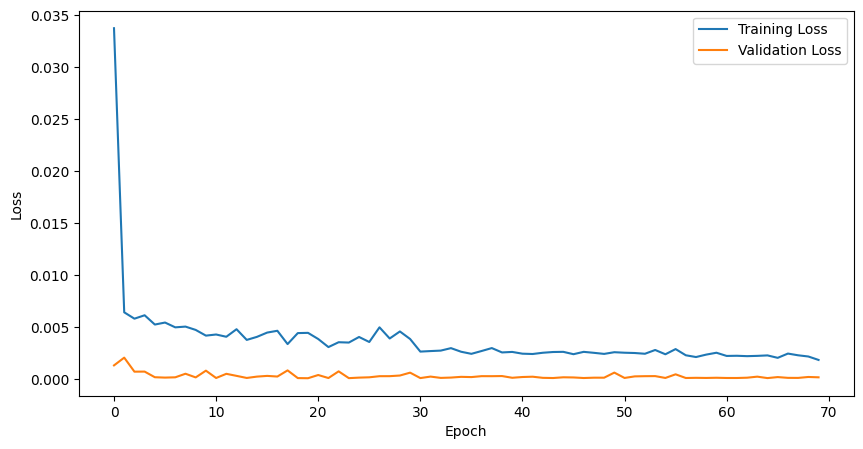

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

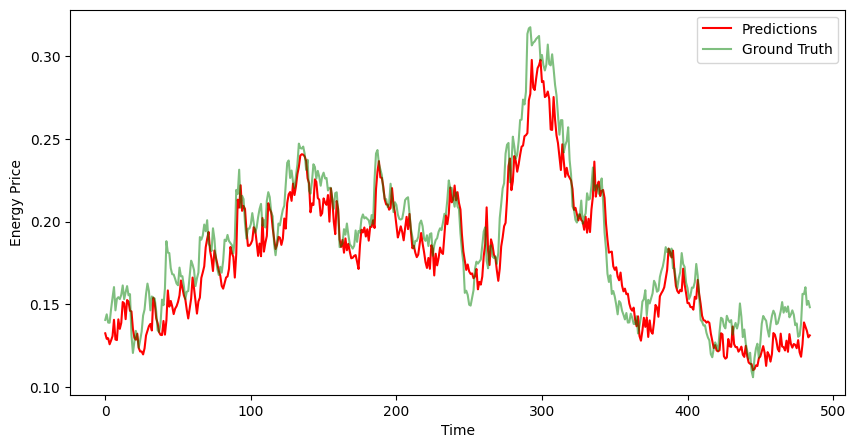

In [ ]:
# Obtain model predictions on the test set
cnn_model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        ground_truth.extend(targets.cpu().numpy())

# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', color='r')
plt.plot(ground_truth, label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

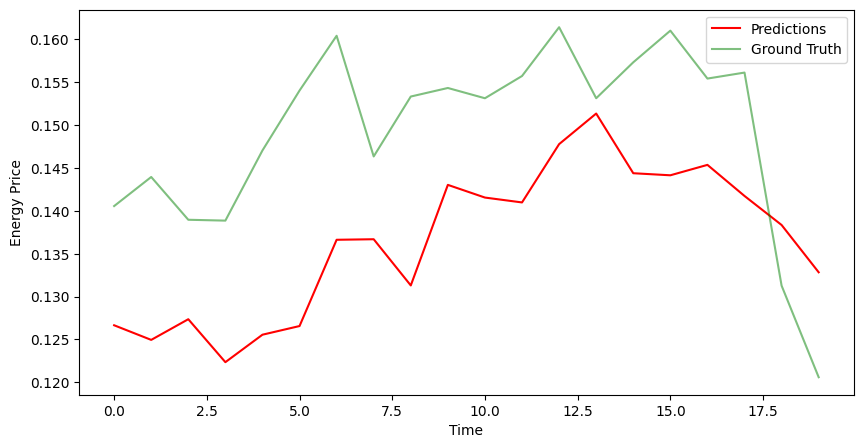

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(predictions[0:20], label='Predictions', color='r')
plt.plot(ground_truth[0:20], label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

In [ ]:
# Run the model on the validation dataset and store the predictions
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        ground_truth.extend(targets.tolist())

# Calculate the daily returns
daily_returns = [ground_truth[i] - ground_truth[i - 1] for i in range(1, len(ground_truth))]

# Calculate the model's up/down predictions and actual up/down movements
predicted_up_down = [1 if predictions[i] > predictions[i - 1] else -1 for i in range(1, len(predictions))]
actual_up_down = [1 if daily_returns[i] > 0 else -1 for i in range(len(daily_returns))]

# Initialize the profit and loss for correct and incorrect predictions
correct_positive_sum = 0
incorrect_positive_sum = 0

# Iterate through the predictions and actual up/down movements
for i in range(len(predicted_up_down)):
    # If the prediction matches the actual movement
    if predicted_up_down[i] == actual_up_down[i]:
        # If the actual movement is up (positive return)
        if actual_up_down[i] == 1:
            # Add the daily return to the correct positive sum
            correct_positive_sum += daily_returns[i]
    # If the prediction doesn't match the actual movement
    else:
        # If the actual movement is up (positive return)
        if actual_up_down[i] == 1:
            # Add the daily return to the incorrect positive sum (as a loss, so we subtract it)
            incorrect_positive_sum -= daily_returns[i]

print(f"Profit from correct predictions: {correct_positive_sum}")
print(f"Loss from incorrect predictions: {incorrect_positive_sum}")

Profit from correct predictions: 0.3037835508584976
Loss from incorrect predictions: -0.2972945999354124
